# Multi-Layer Perceptron with MNIST
*To prepare for the project, I review my knowledge by rewriting MNIST classification using MLP.*

In [81]:
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

## Load and visualize data
We can get MNIST data using PyTorch: https://pytorch.org/docs/stable/torchvision/datasets.html#mnist.

- download data to a `Dataset`
- create a `DataLoader` from `Dataset`
 - use `Sampler` to split to train and validation sets

In [2]:
def load_dataset():
    transform = transforms.ToTensor()
    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
    return train_data, test_data

In [3]:
train_data, test_data = load_dataset()
len(train_data), len(test_data)

(60000, 10000)

In [4]:
def create_data_loaders(train_data, test_data, batch_size=20, train_ratio=0.8):
    train_size = len(train_data)
    indices = np.arange(train_size)
    split = int(train_size * train_ratio)
    np.random.shuffle(indices) # Randomly choose data for train and validation
    train_index = indices[:split]
    valid_index = indices[split:]

    train_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(train_index))
    valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=SubsetRandomSampler(valid_index))
    test_loader = DataLoader(test_data, batch_size=batch_size)
    
    return train_loader, valid_loader, test_loader

In [26]:
train_loader, valid_loader, test_loader = create_data_loaders(train_data, test_data, batch_size=32)

## Visualize a batch of training data
- get a batch from data loader
- use `imshow`

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
labels = labels.numpy()
images[0].shape

(1, 28, 28)

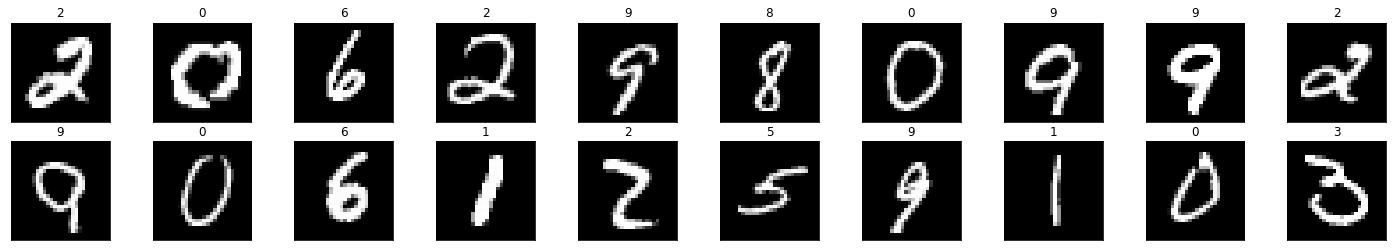

In [7]:
fig = plt.figure(figsize=(25,4))
for i in range(20):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(labels[i])

## Define network architecture
The network takes on an input of 784-dim tensor (as pixel values of an image) and produces a 10-dim tensor of class scores. I will use two hidden layers and dropout to avoid overfitting.

In [8]:
class Network(nn.Module):
    def __init__(self, n_hidden1=512, n_hidden2=128):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(784, n_hidden1)
        self.fc2 = nn.Linear(n_hidden1, n_hidden2)
        self.fc3 = nn.Linear(n_hidden2, 10)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [9]:
model = Network()
model

Network(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Train the network

First is to specify loss function and optimizer.

In [13]:
criterion = nn.CrossEntropyLoss() # takes scores as input
optimizer = optim.SGD(model.parameters(), lr=0.01)

Remember to set the training mode and follow the steps to train each batch:
1. Clear the gradients of all optimized variables
2. Run the forward pass
3. Calculate the loss
4. Run the backward propagation to compute the gradient of the loss w.r.t model parameters
5. Update parameters using optimization step
6. Update average training loss for monitoring

After training the model for each epoch, calculate the validation loss with step 2, 3 and 6.

In [86]:
def train_epoch(model, loader, criterion, optimizer):
    total_loss = 0
    model.train()
    
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)

    return total_loss / len(loader.sampler)

def validate_epoch(model, loader, criterion):
    total_loss = 0
    model.eval()
    
    for data, target in loader:
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)

    return total_loss / len(loader.sampler)

def train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=1):
    valid_loss_min = np.Inf
    
    for epoch in range(n_epochs):
        train_loss = train_epoch(model, train_loader, criterion, optimizer)
        valid_loss = validate_epoch(model, valid_loader, criterion)
        
        print(f'Epoch: {epoch+1} \tTraining loss: {train_loss:.3f} \tValidation loss: {valid_loss:.3f}')
        
        # Save model if validation has decreases
        if valid_loss < valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.3f} -> {valid_loss:.3f}). Saving model...')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), 'model.pt')

In [88]:
train_model(model, train_loader, valid_loader, criterion, optimizer, n_epochs=5)

Epoch: 1 	Training loss: 0.072 	Validation loss: 0.081
Validation loss decreased (inf -> 0.081). Saving model...
Epoch: 2 	Training loss: 0.069 	Validation loss: 0.079
Validation loss decreased (0.081 -> 0.079). Saving model...
Epoch: 3 	Training loss: 0.065 	Validation loss: 0.078
Validation loss decreased (0.079 -> 0.078). Saving model...
Epoch: 4 	Training loss: 0.063 	Validation loss: 0.076
Validation loss decreased (0.078 -> 0.076). Saving model...
Epoch: 5 	Training loss: 0.060 	Validation loss: 0.075
Validation loss decreased (0.076 -> 0.075). Saving model...


## Test the trained network

In [89]:
def test_model(model, loader):
    total_loss = 0
    model.eval()
    preds = torch.LongTensor([])
    labels = torch.LongTensor([])
    
    for data, target in loader:
        output = model(data)
        loss = criterion(output, target)
        total_loss += loss.item() * data.size(0)
        
        _, pred = torch.max(output, 1)
        preds = torch.cat((preds, pred))
        labels = torch.cat((labels, target))
        
    total_loss /= len(loader.sampler)
    print(f'Test loss: {total_loss:.3f}')
    
    acc = accuracy_score(labels, preds)
    print(f'Accuracy: {acc:.2f}')

In [90]:
model.load_state_dict(torch.load('model.pt'))
test_model(model, test_loader)

Test loss: 0.072
Accuracy: 0.98


That's it for a multi-layer perceptron with 2 hidden fully connected layers. The model gave an accuracy of 98% after 5 epochs of training.